In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
all_contracts = all_instruments("Future")
match = r'\w{1,2}88'
continious_contracts = all_contracts[all_contracts.order_book_id.str.contains(match)]
continious_contracts = continious_contracts.where(continious_contracts["product"] == "Commodity").dropna(how="all")
all_commodity = sorted(set(continious_contracts.underlying_symbol))

In [3]:
continious_contracts.set_index("order_book_id",inplace = True)

In [ ]:
continious_contracts.symbol.apply(lambda x : x if "麦" in x else np.nan).dropna()

In [4]:
# 螺纹钢，铁矿石
pairs1 = ["RB","I"]
# 焦煤，焦炭
pairs2 = ["JM","J"]
# 鸡蛋，玉米，豆粕
pairs3 = ["JD","M"]
# ,"C"
# 强麦，硬麦
# pairs4 = ["WH","WT"]
# 银，金
pairs5 = ["AG","AU"]
# 铜，锌
pairs6 = ["CU","ZN"]

In [ ]:
def winsorized(series,n = 3):
  median = series.median()
  median_distance = abs(series - median).median()
  return series.clip(median-n*median_distance,median+n*median_distance)


In [13]:
def get_efficient(pairs,start_date,end_date):
  close_price = list(map(lambda x: get_price(x+"88",start_date,end_date,fields="close"),pairs))
#   print(close_price)
  pairs_data = pd.concat([close_price[0],close_price[1]],axis=1).dropna()
  pairs_data.columns = [pairs[0],pairs[1]]
  linreg = LinearRegression(fit_intercept=False)
  params_coef = linreg.fit(pairs_data.iloc[:,0].values.reshape(-1,1),pairs_data.iloc[:,1]).coef_
  if params_coef>1:
    return {"x": pairs[0],"y":pairs[1],"efficient":int(params_coef)}
  
  linreg = LinearRegression(fit_intercept=False)
  params_coef = linreg.fit(pairs_data.iloc[:,1].values.reshape(-1,1),pairs_data.iloc[:,0]).coef_
  if params_coef>1:
    return {"x": pairs[1],"y":pairs[0],"efficient":int(params_coef)}
  
  return {"x": pairs[0],"y":pairs[1],"efficient":1}

In [14]:
def get_backTest_sharpe(pairs,k1,k2,windows):
  pairs_results = get_efficient(pairs,"2013-01-01","2018-01-01")
  y = get_price(pairs_results.get("y")+"88","2013-01-01","2018-01-01",fields="close",frequency='1m')
  x = get_price(pairs_results.get("x")+"88","2013-01-01","2018-01-01",fields="close",frequency='1m')
  spread = y - x*pairs_results.get("efficient")

  spread_avg = spread.rolling(center=False,window=windows).mean()
  spread_std = spread.rolling(center=False,window=windows).std()
  # 上下届
  up_point = spread_avg+k1*spread_std
  down_point = spread_avg-k2*spread_std

  # 卖出价差：1：y 价格 处于高位 ；x价格 处于低位, 买x，卖y
  # 买入价差：-1：x 价格处于高位 ；y价格 处于低位，买y，卖x
  signal_S = (spread > up_point).astype(int)
  signal = (spread < down_point).astype(int).replace([0,1],[np.nan,-1]).fillna(signal_S)

  y_chg = y.pct_change().shift(-1)
  x_chg = x.pct_change().shift(-1)

  combined_data = pd.concat([signal,x_chg,y_chg],axis=1)
  combined_data.columns = ["signal","x_chg","y_chg"]

  # x与y的收益率差， 当期至下一时期的收益率
  combined_data["DIFF"] = (combined_data["x_chg"] - combined_data["y_chg"])
  rets = (combined_data["signal"]*combined_data["DIFF"])
  sharpe = rets.mean()/rets.std()
  return sharpe
  

In [15]:
results = {}
i = 0



In [ ]:

k1_list = [2,3]
k2_list = [2,3]
windows_list = np.arange(20,90,10)
pairs_list = {"pairs1":pairs1,"pairs2":pairs2,"pairs3":pairs3,"pairs5":pairs5,"pairs6":pairs6}
# pairs_list = {"pairs6":pairs6}



for k1 in k1_list:
  for k2 in k2_list:
    for pairs in pairs_list.keys():
      for windows in windows_list:
        print(i,k1,k2,pairs,windows)
        sharpe = get_backTest_sharpe(pairs_list.get(pairs),k1,k2,windows)
        res = pd.Series([sharpe,k1,k2,pairs,windows],index = ["sharpe","k1","k2","pairs","windows"])
        results[i] = res
        i+=1


      


0 2 2 pairs5 20


In [27]:
pairs_results = pd.DataFrame(results).T.set_index(["pairs","windows"]).sort_index()

In [29]:
pairs_results.sort_values(by="sharpe",ascending=False)

sharpe k1 k2
pairs  windows                 
pairs1 30        0.105857  2  2
       40          0.1019  2  2
       20        0.100352  2  2
       50       0.0978806  2  2
       60       0.0918111  2  2
pairs2 40       0.0899824  2  2
       20       0.0879231  2  2
       30        0.087913  2  2
pairs1 80        0.086701  2  2
pairs2 50         0.08659  2  2
pairs1 70       0.0846364  2  2
       30       0.0814278  3  2
       40       0.0812479  3  2
       50       0.0783205  3  2
pairs2 80       0.0780948  2  2
pairs1 20       0.0770612  3  2
pairs2 40       0.0761346  2  3
pairs1 30       0.0744152  2  3
pairs2 50       0.0739958  2  3
       60       0.0737445  2  2
pairs1 60       0.0730318  3  2
pairs2 60       0.0721001  2  3
pairs1 40       0.0718922  2  3
pairs2 70       0.0715957  2  2
       70       0.0707315  2  3
       30       0.0701258  2  3
pairs1 50       0.0700468  2  3
pairs2 80       0.0688717  2  3
pairs1 80       0.0686108  2  3
pairs2 20       0.0684068  2  3
...                   ... .. ..
pairs5 70       0.0204048  3  3
pairs3 60       0.0200418  3  3
pairs5 60       0.0198042  3  3
pairs3 50       0.0195884  3  2
pairs5 40       0.0194765  3  3
       50       0.0187579  3  3
       80       0.0185536  3  3
pairs3 70       0.0183815  3  3
pairs6 40       0.0181499  3  3
pairs3 60       0.0178871  3  2
pairs5 30       0.0178125  3  3
pairs6 30       0.0173166  3  3
pairs3 50       0.0172338  2  2
pairs6 50       0.0168201  3  3
pairs3 60       0.0164161  2  2
       20       0.0162799  3  2
       80       0.0160233  3  3
       70       0.0159266  3  2
pairs6 70       0.0157236  3  3
       80       0.0156455  3  3
       60       0.0155706  3  3
pairs3 50       0.0149859  2  3
       80       0.0146658  3  2
       70       0.0146446  2  2
       60       0.0140111  2  3
pairs5 20       0.0133172  3  3
pairs6 20       0.0131298  3  3
pairs3 70       0.0128486  2  3
       80       0.0128139  2  2
       80       0.0107852  2  3

[140 rows x 3 columns]

In [30]:
get_efficient(pairs1,"2013-01-01","2018-01-01")

{'efficient': 5, 'x': 'I', 'y': 'RB'}

In [31]:
get_efficient(pairs2,"2013-01-01","2018-01-01")

{'efficient': 1, 'x': 'JM', 'y': 'J'}

In [32]:
get_efficient(pairs3,"2013-01-01","2018-01-01")

{'efficient': 1, 'x': 'M', 'y': 'JD'}

In [34]:
get_efficient(pairs5,"2013-01-01","2018-01-01")

{'efficient': 15, 'x': 'AU', 'y': 'AG'}

In [35]:
get_efficient(pairs6,"2013-01-01","2018-01-01")

{'efficient': 2, 'x': 'ZN', 'y': 'CU'}

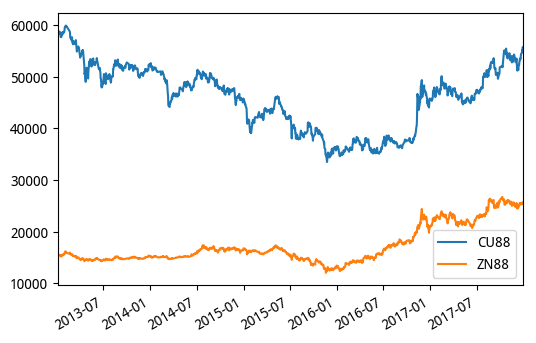

In [40]:
get_price([i+"88" for i in pairs6],"2013-01-01","2018-01-01",fields="close").dropna().plot()